**Description:** This file contains test code for the [sr-MO-BO-3GP approach](https://asmedigitalcollection.asme.org/mechanicaldesign/article/144/3/031705/1119624/srMO-BO-3GP-A-Sequential-Regularized-Multi) when used to solve two-objective optimization problems. We use four test problems: Fonseca, Kursawe, Omni, and ZDT3. In this test case, the sr-MO-BO-3GP approach does not use the GP classifier of the Pareto front.
- If you want to test a GP model different from the one used in the paper, use the src/vanilla_GP_model.py file to modify the model (kernel and mean function).
- The proposed and benhcmark approaches make use of tensorflow-probability version 0.23.0. A different version migth lead to execution errors. Check the requirements.txt file for the necessary libraries to test the repo.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp # Be sure that you have installed this version: tensorflow-probability==0.23.0
import gpflow as gpf
import scipy.io
from sklearn.preprocessing import MinMaxScaler
from pymoo.indicators.hv import HV
import warnings
warnings.filterwarnings("ignore")

# Import in-house functions for multiobjective optimization 
import src.test_functions as test_function
from src.vanilla_GP_model import build_gpr_model_sr_MO_BO_3GP
from src.vanilla_GP_model import train_gpr_model_sr_MO_BO_3GP
from src.sr_MO_BO_3GP_approach import Augmented_Tchebycheff, Composed_acquisition_function_penalized_no_classifier
from src.find_pareto import Pareto_front
from src.optimization import find_new_design_sr_MO_BO_3GP_no_classifier

d:\Github_projects\jmd-epdc\.venv\Lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
d:\Github_projects\jmd-epdc\.venv\Lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


**Fonseca test problem:** Problem with a non-convex Pareto front and two design variables.

Optimization settings

In [ ]:
test_index = 0 # select a test index from 0 to 4 (to retrive the initial sampling plan located in the data directory).
total_iter = 100 # Total number of iterations
n_dimensions = 2 # Number of dimensions of the optimization problem
X_bounds = np.concatenate((-4*np.ones((1,n_dimensions)),4*np.ones((1,n_dimensions))),0) # Box constraints of the optimization problem

# Settings sr-MOBO approach
rho_tb = 0.65
lambda_tb = 0.01
Beta = 0.95
Slack = 10
# Update weighting vector according to the number of iterations
weights_dic = scipy.io.loadmat('data/DOE_weights_2_obj_100.mat')
weights_sde = weights_dic.get('w_DOE_samples')

num_steps_optimizer = 400  # Number of iterations of SGD-based optimizer (300 - 400)
learning_rate = 0.25  # Learning rate optimizer

n_samples_opt = np.min((25 * n_dimensions, 500)) # Number of points for multi-point optimization of the EPDC
eff_length = ((0.05 ** 2) * n_dimensions) ** 0.5  # Effective lenght for penalization of similar designs
ref_point = np.array([1., 1.]) # Reference point for calculation of dominated hypervolume

Optimization loop

Iteration: 1
New design: [-0.31985927 -1.84432486]
Initial HV: 0.012290774606169553
Current HV: 0.012290774606169553
Acquisition function: 10.008546
UCB Neg. augmented_Tchebycheff: 10.012069


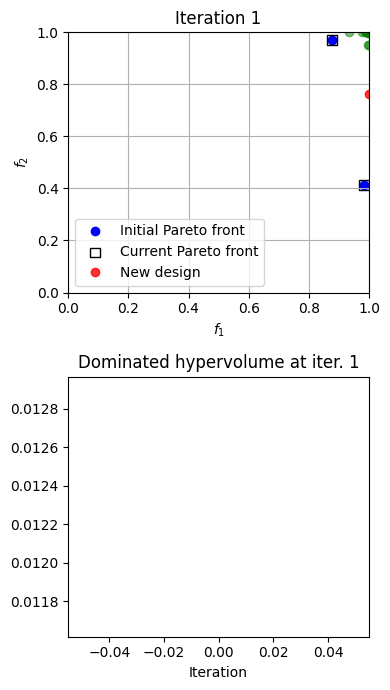

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
New design: [-0.93544852 -0.32712655]
Initial HV: 0.012290774606169553
Current HV: 0.20973567535512683
Acquisition function: 9.336649
UCB Neg. augmented_Tchebycheff: 9.360673


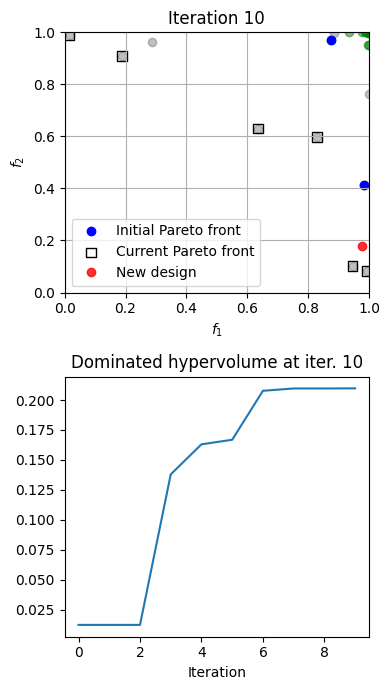

Optimization completed ...


In [4]:
# Import initial sampling plan. We are using a sampling plan located in the data directory to enable reproducibility of results.
X_train_dic = scipy.io.loadmat('data/two_objective_Fonseca_2_dv.mat')
X_train_lhs = X_train_dic.get('X_initial')

# Evaluate sampling plan
X_train = X_train_lhs[:, :, test_index]
n_init = X_train.shape[0]
F_train = test_function.Fonseca(X_train, n_dimensions)
n_objectives = F_train.shape[1]  # number of objectives

# Arrays to track behaviour of optimization approach
HV_optimization = np.zeros((total_iter, 1))
NaN_flag_1 = np.zeros(total_iter) # Flag to check if NaN values are found in the hyperparemters of GPR model 1
NaN_flag_2 = np.zeros(total_iter) # Flag to check if NaN values are found in the hyperparemters of GPR model 2

# Normalization of inputs outside optimization loop as we know its maximum and minimum values
scaler_X = MinMaxScaler()
scaler_X.fit(X_bounds)

# Bayesian optimization loop
for iter in range(total_iter):
    # Sample weights
    weights_tb = weights_sde[iter]
    # Find Pareto front and Pareto set
    # Pareto designs: O if dominated, 1 if not dominated
    Pareto_index = Pareto_front(F_train)
    # Pareto front
    PF = F_train[Pareto_index]
    # Pareto designs
    PD = X_train[Pareto_index, :]

    # Create scaler instances
    scaler_Y = MinMaxScaler()
    scaler_Y.fit(F_train)
    # Normalize PF, PD, and training data
    PFn, PDn = scaler_Y.transform(PF), scaler_X.transform(PD)
    F_train_n, X_train_n = scaler_Y.transform(F_train), scaler_X.transform(X_train)

    # Record initial Pareto front and Pareto set
    if iter == 0:
        # Pareto designs
        PF_init = PF
        PD_init = PD

    # Transform data according to Augmented_Tchebycheff function
    F_aug_Tcheb = Augmented_Tchebycheff(X_train_n, F_train_n, weights_tb, rho_tb, lambda_tb)
    F_aug_Tcheb_neg = -F_aug_Tcheb

    # Build GPR model of the negative augmented_Tchebycheff function
    m = build_gpr_model_sr_MO_BO_3GP(X_train_n, F_aug_Tcheb_neg)

    # Train GPR model of the negative augmented_Tchebycheff function
    m, NaN_flag_1 = train_gpr_model_sr_MO_BO_3GP(m, X_train_n, F_aug_Tcheb_neg, NaN_flag_1, iter)
   
    #%% ############## Optimization of acquisition function to find a new design for sampling
    # Transformation of variables to enforce box constraints
    lb_X = np.float64(np.zeros(n_dimensions))
    ub_X = np.float64(np.ones(n_dimensions))
    Sigmoid_X = tfp.bijectors.Sigmoid(low=lb_X, high=ub_X)
    scaling_opt = 1
    x_new = find_new_design_sr_MO_BO_3GP_no_classifier(m, Composed_acquisition_function_penalized_no_classifier, X_train_n, Beta, Slack, eff_length, n_samples_opt, n_dimensions, learning_rate, num_steps_optimizer, Sigmoid_X, scaling_opt)

    #%% ############## Evaluate new design
    x_new_original = scaler_X.inverse_transform(x_new)
    F_new = test_function.Fonseca(x_new_original, n_dimensions)

    #%% ############## Optimization performance metrics
    ind_0 = HV(ref_point=ref_point)
    initial_HV = ind_0(PF_init)
    ind_i = HV(ref_point=ref_point)
    HV_optimization[iter, :] = ind_i(PF)
    scaling_opt = 0
    AF_i, UCB_i, penal_dist_x_i  = Composed_acquisition_function_penalized_no_classifier(x_new, m, Beta, Slack, Sigmoid_X, X_train_n, eff_length, scaling_opt)

    print("Iteration:", iter + 1)
    
    # #%% ############## Visualization and tracing evolution of optimization
    # Plot every 10 iterations
    if ((iter + 1) % 10 == 0) or (iter == 0):        
        print("New design:", x_new_original[0])
        print("Initial HV:", initial_HV)
        print("Current HV:", ind_i(PF))
        print("Acquisition function:", -AF_i.numpy()[0, 0])
        print("UCB Neg. augmented_Tchebycheff:", UCB_i.numpy()[0, 0])

        plt.figure(figsize=(4, 7))
        ax1 = plt.subplot(211)
        ax1.grid()
        plt.scatter(F_train[:n_init, 0], F_train[:n_init, 1], c='green', alpha=0.5) # 'Initial designs'
        plt.scatter(F_train[n_init:, 0], F_train[n_init:, 1], c='gray', alpha=0.5) #'Sampled designs'
        plt.scatter(PF_init[:, 0], PF_init[:, 1], c='blue', label = 'Initial Pareto front')
        plt.scatter(PF[:, 0], PF[:, 1], marker= 's', s=50, facecolors='none', edgecolors='k', label = 'Current Pareto front')
        plt.plot(F_new[0:, 0], F_new[0:, 1], 'ro', alpha=0.8, label = 'New design')
        ax1.set_xlabel('$f_1$')
        ax1.set_ylabel('$f_2$')
        ax1.set_title('Iteration ' + str(iter + 1))
        ax1.legend(loc='lower left')
        ax1.set_xlim([0, 1])
        ax1.set_ylim([0, 1])

        ax2 = plt.subplot(212)
        ax2.plot(HV_optimization[:iter+1,0])
        ax2.set_xlabel('Iteration')
        ax2.title.set_text('Dominated hypervolume at iter. ' + str(iter + 1))
        plt.tight_layout()
        plt.show()

    # %% Update training data
    F_train = np.concatenate((F_train, F_new), 0)
    X_train = np.concatenate((X_train, x_new_original), 0)
print('Optimization completed ...')

**Kursawe test problem:** Problem with a segmented Pareto front and three design variables.

Optimization settings

In [ ]:
test_index = 0 # select a test index from 0 to 4 (to retrive the initial sampling plan located in the data directory).
total_iter = 100 # Total number of iterations
n_dimensions = 3 # Number of dimensions of the optimization problem
X_bounds = np.concatenate((-5*np.ones((1,n_dimensions)),5*np.ones((1,n_dimensions))),0) # Box constraints of the optimization problem

# Settings sr-MOBO approach
rho_tb = 0.65
lambda_tb = 0.01
Beta = 0.95
Slack = 10
# Update weighting vector according to the number of iterations
weights_dic = scipy.io.loadmat('data/DOE_weights_2_obj_100.mat')
weights_sde = weights_dic.get('w_DOE_samples')

num_steps_optimizer = 400  # Number of iterations of SGD-based optimizer (300 - 400)
learning_rate = 0.25  # Learning rate optimizer

n_samples_opt = np.min((25 * n_dimensions, 500)) # Number of points for multi-point optimization of the EPDC
eff_length = ((0.05 ** 2) * n_dimensions) ** 0.5  # Effective lenght for penalization of similar designs
ref_point = np.array([-6., 15.])# Reference point for calculation of dominated hypervolume

Optimization loop

Iteration: 1
New design: [ 2.10785558  3.23481234 -1.16625806]
Initial HV: 137.77833276623036
Current HV: 137.77833276623036
Acquisition function: 10.055617
UCB Neg. augmented_Tchebycheff: 10.055637
Iteration: 1
New design: [ 2.10785558  3.23481234 -1.16625806]
Initial HV: 137.77833276623036
Current HV: 137.77833276623036
Acquisition function: 10.055617
UCB Neg. augmented_Tchebycheff: 10.055637


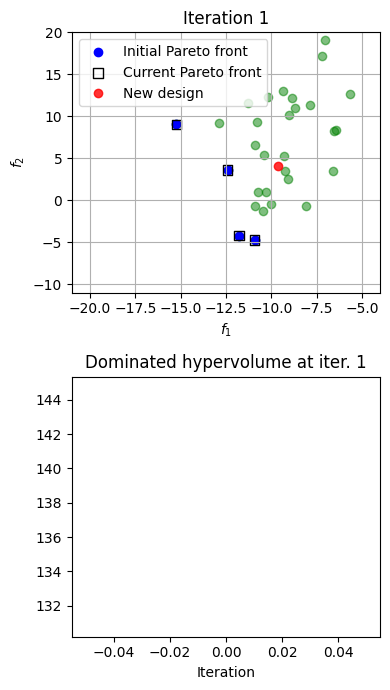

Iteration: 2
Iteration: 2
Iteration: 3
Iteration: 3
Iteration: 4
Iteration: 4
Iteration: 5
Iteration: 5
Iteration: 6
Iteration: 6
Iteration: 7
Iteration: 7
Iteration: 8
Iteration: 8
Iteration: 9
Iteration: 9
Iteration: 10
New design: [-1.50383932 -0.26833337 -0.12374992]
Initial HV: 137.77833276623036
Current HV: 224.13776028042656
Acquisition function: 9.94032
UCB Neg. augmented_Tchebycheff: 9.947433
Iteration: 10
New design: [-1.50383932 -0.26833337 -0.12374992]
Initial HV: 137.77833276623036
Current HV: 224.13776028042656
Acquisition function: 9.94032
UCB Neg. augmented_Tchebycheff: 9.947433


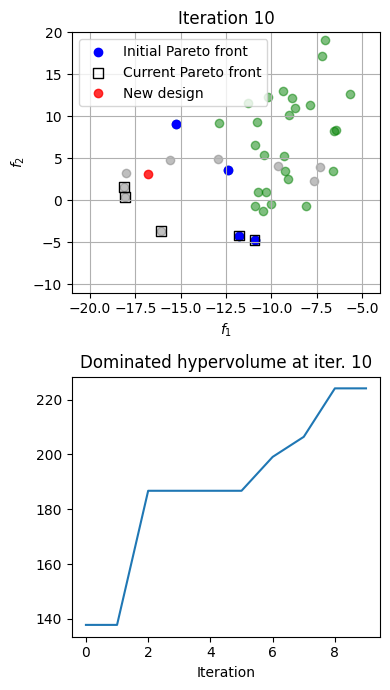

Optimization completed ...


In [7]:
# Import initial sampling plan. We are using a sampling plan located in the data directory to enable reproducibility of results.
X_train_dic = scipy.io.loadmat('data/two_objective_Kursawe_3_dv.mat')
X_train_lhs = X_train_dic.get('X_initial')

# Evaluate sampling plan
X_train = X_train_lhs[:, :, test_index]
n_init = X_train.shape[0]
F_train = test_function.Kursawe(X_train)
n_objectives = F_train.shape[1]  # number of objectives

# Arrays to track behaviour of optimization approach
HV_optimization = np.zeros((total_iter, 1))
NaN_flag_1 = np.zeros(total_iter) # Flag to check if NaN values are found in the hyperparemters of GPR model 1
NaN_flag_2 = np.zeros(total_iter) # Flag to check if NaN values are found in the hyperparemters of GPR model 2

# Normalization of inputs outside optimization loop as we know its maximum and minimum values
scaler_X = MinMaxScaler()
scaler_X.fit(X_bounds)

# Bayesian optimization loop
for iter in range(total_iter):
    # Sample weights
    weights_tb = weights_sde[iter]
    # Find Pareto front and Pareto set
    # Pareto designs: O if dominated, 1 if not dominated
    Pareto_index = Pareto_front(F_train)
    # Pareto front
    PF = F_train[Pareto_index]
    # Pareto designs
    PD = X_train[Pareto_index, :]

    # Create scaler instances
    scaler_Y = MinMaxScaler()
    scaler_Y.fit(F_train)
    # Normalize PF, PD, and training data
    PFn, PDn = scaler_Y.transform(PF), scaler_X.transform(PD)
    F_train_n, X_train_n = scaler_Y.transform(F_train), scaler_X.transform(X_train)

    # Record initial Pareto front and Pareto set
    if iter == 0:
        # Pareto designs
        PF_init = PF
        PD_init = PD

    # Transform data according to Augmented_Tchebycheff function
    F_aug_Tcheb = Augmented_Tchebycheff(X_train_n, F_train_n, weights_tb, rho_tb, lambda_tb)
    F_aug_Tcheb_neg = -F_aug_Tcheb

    # Build GPR model of the negative augmented_Tchebycheff function
    m = build_gpr_model_sr_MO_BO_3GP(X_train_n, F_aug_Tcheb_neg)

    # Train GPR model of the negative augmented_Tchebycheff function
    m, NaN_flag_1 = train_gpr_model_sr_MO_BO_3GP(m, X_train_n, F_aug_Tcheb_neg, NaN_flag_1, iter)
   
    #%% ############## Optimization of acquisition function to find a new design for sampling
    # Transformation of variables to enforce box constraints
    lb_X = np.float64(np.zeros(n_dimensions))
    ub_X = np.float64(np.ones(n_dimensions))
    Sigmoid_X = tfp.bijectors.Sigmoid(low=lb_X, high=ub_X)
    scaling_opt = 1
    x_new = find_new_design_sr_MO_BO_3GP_no_classifier(m, Composed_acquisition_function_penalized_no_classifier, X_train_n, Beta, Slack, eff_length, n_samples_opt, n_dimensions, learning_rate, num_steps_optimizer, Sigmoid_X, scaling_opt)

    #%% ############## Evaluate new design
    x_new_original = scaler_X.inverse_transform(x_new)
    F_new = test_function.Kursawe(x_new_original)

    #%% ############## Optimization performance metrics
    ind_0 = HV(ref_point=ref_point)
    initial_HV = ind_0(PF_init)
    ind_i = HV(ref_point=ref_point)
    HV_optimization[iter, :] = ind_i(PF)
    scaling_opt = 0
    AF_i, UCB_i, penal_dist_x_i  = Composed_acquisition_function_penalized_no_classifier(x_new, m, Beta, Slack, Sigmoid_X, X_train_n, eff_length, scaling_opt)

    print("Iteration:", iter + 1)
    
    # #%% ############## Visualization and tracing evolution of optimization
    # Plot every 10 iterations
    if ((iter + 1) % 10 == 0) or (iter == 0):        
        print("New design:", x_new_original[0])
        print("Initial HV:", initial_HV)
        print("Current HV:", ind_i(PF))
        print("Acquisition function:", -AF_i.numpy()[0, 0])
        print("UCB Neg. augmented_Tchebycheff:", UCB_i.numpy()[0, 0])
    
    print("Iteration:", iter + 1)

    # #%% ############## Visualization and tracing evolution of optimization
    # Plot every 10 iterations
    if ((iter + 1) % 10 == 0) or (iter == 0):        
        print("New design:", x_new_original[0])
        print("Initial HV:", initial_HV)
        print("Current HV:", ind_i(PF))
        print("Acquisition function:", -AF_i.numpy()[0, 0])
        print("UCB Neg. augmented_Tchebycheff:", UCB_i.numpy()[0, 0])
    
        plt.figure(figsize=(4, 7))
        ax1 = plt.subplot(211)
        ax1.grid()
        plt.scatter(F_train[:n_init, 0], F_train[:n_init, 1], c='green', alpha=0.5) # 'Initial designs'
        plt.scatter(F_train[n_init:, 0], F_train[n_init:, 1], c='gray', alpha=0.5) #'Sampled designs'
        plt.scatter(PF_init[:, 0], PF_init[:, 1], c='blue', label = 'Initial Pareto front')
        plt.scatter(PF[:, 0], PF[:, 1], marker= 's', s=50, facecolors='none', edgecolors='k', label = 'Current Pareto front')
        plt.plot(F_new[0:, 0], F_new[0:, 1], 'ro', alpha=0.8, label = 'New design')
        ax1.set_xlabel('$f_1$')
        ax1.set_ylabel('$f_2$')
        ax1.set_title('Iteration ' + str(iter + 1))
        ax1.legend(loc='upper left')
        ax1.set_xlim([-21, -4])
        ax1.set_ylim([-11, 20])

        ax2 = plt.subplot(212)
        ax2.plot(HV_optimization[:iter+1,0])
        ax2.set_xlabel('Iteration')
        ax2.title.set_text('Dominated hypervolume at iter. ' + str(iter + 1))
        plt.tight_layout()
        plt.show()

    # %% Update training data
    F_train = np.concatenate((F_train, F_new), 0)
    X_train = np.concatenate((X_train, x_new_original), 0)
print('Optimization completed ...')

**Omni test problem:** Problem with a convex Pareto front and six design variables.

Optimization settings

In [ ]:
test_index = 0 # select a test index from 0 to 4 (to retrive the initial sampling plan located in the data directory).
total_iter = 200 # Total number of iterations
n_dimensions = 6 # Number of dimensions of the optimization problem
X_bounds = np.concatenate((np.zeros((1,n_dimensions)),6*np.ones((1,n_dimensions))),0) # Box constraints of the optimization problem

# Settings sr-MOBO approach
rho_tb = 0.65
lambda_tb = 0.01
Beta = 0.95
Slack = 10
# Update weighting vector according to the number of iterations
weights_dic = scipy.io.loadmat('data/DOE_weights_2_obj_200.mat')
weights_sde = weights_dic.get('w_DOE_samples')

num_steps_optimizer = 400  # Number of iterations of SGD-based optimizer (300 - 400)
learning_rate = 0.25  # Learning rate optimizer

n_samples_opt = np.min((25 * n_dimensions, 500)) # Number of points for multi-point optimization of the EPDC
eff_length = ((0.05 ** 2) * n_dimensions) ** 0.5  # Effective lenght for penalization of similar designs
ref_point = np.array([0., 0.]) # Reference point for calculation of dominated hypervolume

Optimization loop

Iteration: 1
New design: [4.95924761 0.44858056 1.32635047 5.99004918 0.50346285 5.37913168]
Initial HV: 11.40399202670268
Current HV: 11.40399202670268
Acquisition function: 9.944302
UCB Neg. augmented_Tchebycheff: 9.944302


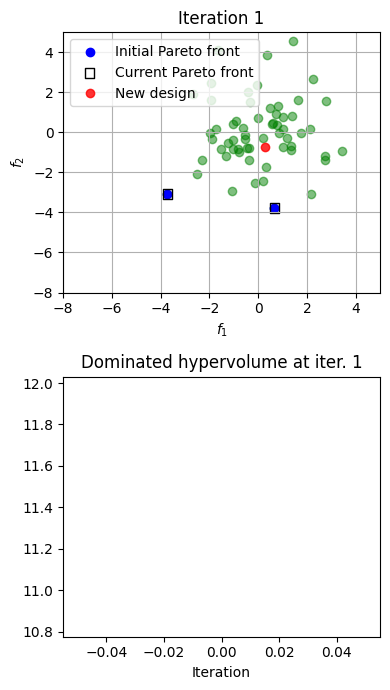

Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
New design: [5.94239397 0.34255575 1.40059186 5.33772612 5.4457074  3.52821148]
Initial HV: 11.40399202670268
Current HV: 13.716165367422331
Acquisition function: 10.056781
UCB Neg. augmented_Tchebycheff: 10.056864


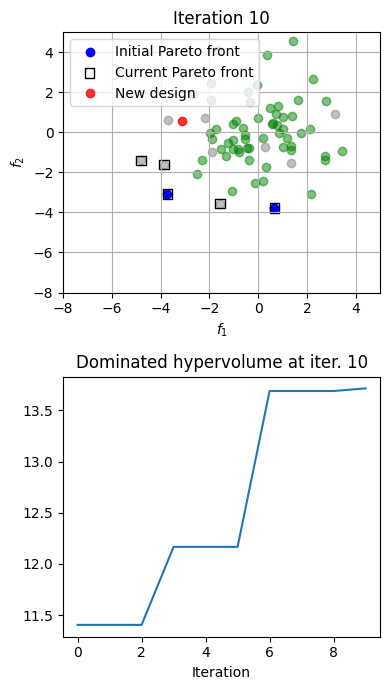

Optimization completed ...


In [9]:
# Import OmniTest from pymoo
from pymoo.problems.multi.omnitest import OmniTest
Test_function_pymoo = OmniTest(n_var = n_dimensions)

# Import initial sampling plan
X_train_dic = scipy.io.loadmat('data/two_objective_Omni_6_dv.mat')
X_train_lhs = X_train_dic.get('X_initial')

# Evaluate sampling plan
X_train = X_train_lhs[:, :, test_index]
n_init = X_train.shape[0]
F_train = Test_function_pymoo.evaluate(X_train, return_values_of=["F"])
n_objectives = F_train.shape[1]  # number of objectives

# Arrays to track behaviour of optimization approach
HV_optimization = np.zeros((total_iter, 1))
NaN_flag_1 = np.zeros(total_iter) # Flag to check if NaN values are found in the hyperparemters of GPR model 1
NaN_flag_2 = np.zeros(total_iter) # Flag to check if NaN values are found in the hyperparemters of GPR model 2

# Normalization of inputs outside optimization loop as we know its maximum and minimum values
scaler_X = MinMaxScaler()
scaler_X.fit(X_bounds)

# Bayesian optimization loop
for iter in range(total_iter):
    # Sample weights
    weights_tb = weights_sde[iter]
    # Find Pareto front and Pareto set
    # Pareto designs: O if dominated, 1 if not dominated
    Pareto_index = Pareto_front(F_train)
    # Pareto front
    PF = F_train[Pareto_index]
    # Pareto designs
    PD = X_train[Pareto_index, :]

    # Create scaler instances
    scaler_Y = MinMaxScaler()
    scaler_Y.fit(F_train)
    # Normalize PF, PD, and training data
    PFn, PDn = scaler_Y.transform(PF), scaler_X.transform(PD)
    F_train_n, X_train_n = scaler_Y.transform(F_train), scaler_X.transform(X_train)

    # Record initial Pareto front and Pareto set
    if iter == 0:
        # Pareto designs
        PF_init = PF
        PD_init = PD

    # Transform data according to Augmented_Tchebycheff function
    F_aug_Tcheb = Augmented_Tchebycheff(X_train_n, F_train_n, weights_tb, rho_tb, lambda_tb)
    F_aug_Tcheb_neg = -F_aug_Tcheb

    # Build GPR model of the negative augmented_Tchebycheff function
    m = build_gpr_model_sr_MO_BO_3GP(X_train_n, F_aug_Tcheb_neg)

    # Train GPR model of the negative augmented_Tchebycheff function
    m, NaN_flag_1 = train_gpr_model_sr_MO_BO_3GP(m, X_train_n, F_aug_Tcheb_neg, NaN_flag_1, iter)
   
    #%% ############## Optimization of acquisition function to find a new design for sampling
    # Transformation of variables to enforce box constraints
    lb_X = np.float64(np.zeros(n_dimensions))
    ub_X = np.float64(np.ones(n_dimensions))
    Sigmoid_X = tfp.bijectors.Sigmoid(low=lb_X, high=ub_X)
    scaling_opt = 1
    x_new = find_new_design_sr_MO_BO_3GP_no_classifier(m, Composed_acquisition_function_penalized_no_classifier, X_train_n, Beta, Slack, eff_length, n_samples_opt, n_dimensions, learning_rate, num_steps_optimizer, Sigmoid_X, scaling_opt)

    #%% ############## Evaluate new design
    x_new_original = scaler_X.inverse_transform(x_new)
    F_new = Test_function_pymoo.evaluate(x_new_original, return_values_of=["F"])

    #%% ############## Optimization performance metrics
    ind_0 = HV(ref_point=ref_point)
    initial_HV = ind_0(PF_init)
    ind_i = HV(ref_point=ref_point)
    HV_optimization[iter, :] = ind_i(PF)
    scaling_opt = 0
    AF_i, UCB_i, penal_dist_x_i  = Composed_acquisition_function_penalized_no_classifier(x_new, m, Beta, Slack, Sigmoid_X, X_train_n, eff_length, scaling_opt)
    
    print("Iteration:", iter + 1)

    # #%% ############## Visualization and tracing evolution of optimization
    # Plot every 10 iterations
    if ((iter + 1) % 10 == 0) or (iter == 0):        
        print("New design:", x_new_original[0])
        print("Initial HV:", initial_HV)
        print("Current HV:", ind_i(PF))
        print("Acquisition function:", -AF_i.numpy()[0, 0])
        print("UCB Neg. augmented_Tchebycheff:", UCB_i.numpy()[0, 0])

        plt.figure(figsize=(4, 7))
        ax1 = plt.subplot(211)
        ax1.grid()
        plt.scatter(F_train[:n_init, 0], F_train[:n_init, 1], c='green', alpha=0.5) # 'Initial designs'
        plt.scatter(F_train[n_init:, 0], F_train[n_init:, 1], c='gray', alpha=0.5) #'Sampled designs'
        plt.scatter(PF_init[:, 0], PF_init[:, 1], c='blue', label = 'Initial Pareto front')
        plt.scatter(PF[:, 0], PF[:, 1], marker= 's', s=50, facecolors='none', edgecolors='k', label = 'Current Pareto front')
        plt.plot(F_new[0:, 0], F_new[0:, 1], 'ro', alpha=0.8, label = 'New design')
        ax1.set_xlabel('$f_1$')
        ax1.set_ylabel('$f_2$')
        ax1.set_title('Iteration ' + str(iter + 1))
        ax1.legend(loc='upper left')
        ax1.set_xlim([-8, 5])
        ax1.set_ylim([-8, 5])

        ax2 = plt.subplot(212)
        ax2.plot(HV_optimization[:iter+1,0])
        ax2.set_xlabel('Iteration')
        ax2.title.set_text('Dominated hypervolume at iter. ' + str(iter + 1))
        plt.tight_layout()
        plt.show()

    # %% Update training data
    F_train = np.concatenate((F_train, F_new), 0)
    X_train = np.concatenate((X_train, x_new_original), 0)
print('Optimization completed ...')

**ZDT3:** Problem with a segmented Pareto front and six design variables.

Optimization settings

In [ ]:
test_index = 0 # select a test index from 0 to 4 (to retrive the initial sampling plan located in the data directory).
total_iter = 200 # Total number of iterations
n_dimensions = 6 # Number of dimensions of the optimization problem
X_bounds = np.concatenate((np.zeros((1,n_dimensions)),np.ones((1,n_dimensions))),0) # Box constraints of the optimization problem

# Settings sr-MOBO approach
rho_tb = 0.65
lambda_tb = 0.01
Beta = 0.95
Slack = 10
# Update weighting vector according to the number of iterations
weights_dic = scipy.io.loadmat('data/DOE_weights_2_obj_200.mat')
weights_sde = weights_dic.get('w_DOE_samples')

num_steps_optimizer = 400  # Number of iterations of SGD-based optimizer (300 - 400)
learning_rate = 0.25  # Learning rate optimizer

n_samples_opt = np.min((25 * n_dimensions, 500)) # Number of points for multi-point optimization of the EPDC
eff_length = ((0.05 ** 2) * n_dimensions) ** 0.5  # Effective lenght for penalization of similar designs
ref_point = np.array([1., 7.]) # Reference point for calculation of dominated hypervolume

Optimization loop

In [ ]:
# Import initial sampling plan. We are using a sampling plan located in the data directory to enable reproducibility of results.
X_train_dic = scipy.io.loadmat('data/two_objective_ZDT3_6_dv.mat')
X_train_lhs = X_train_dic.get('X_initial')

# Evaluate sampling plan
X_train = X_train_lhs[:, :, test_index]
n_init = X_train.shape[0]
F_train = test_function.ZDT3(X_train, n_dimensions)
n_objectives = F_train.shape[1]  # number of objectives

# Arrays to track behaviour of optimization approach
HV_optimization = np.zeros((total_iter, 1))
NaN_flag_1 = np.zeros(total_iter) # Flag to check if NaN values are found in the hyperparemters of GPR model 1
NaN_flag_2 = np.zeros(total_iter) # Flag to check if NaN values are found in the hyperparemters of GPR model 2

# Normalization of inputs outside optimization loop as we know its maximum and minimum values
scaler_X = MinMaxScaler()
scaler_X.fit(X_bounds)

# Bayesian optimization loop
for iter in range(total_iter):
    # Sample weights
    weights_tb = weights_sde[iter]
    # Find Pareto front and Pareto set
    # Pareto designs: O if dominated, 1 if not dominated
    Pareto_index = Pareto_front(F_train)
    # Pareto front
    PF = F_train[Pareto_index]
    # Pareto designs
    PD = X_train[Pareto_index, :]

    # Create scaler instances
    scaler_Y = MinMaxScaler()
    scaler_Y.fit(F_train)
    # Normalize PF, PD, and training data
    PFn, PDn = scaler_Y.transform(PF), scaler_X.transform(PD)
    F_train_n, X_train_n = scaler_Y.transform(F_train), scaler_X.transform(X_train)

    # Record initial Pareto front and Pareto set
    if iter == 0:
        # Pareto designs
        PF_init = PF
        PD_init = PD

    # Transform data according to Augmented_Tchebycheff function
    F_aug_Tcheb = Augmented_Tchebycheff(X_train_n, F_train_n, weights_tb, rho_tb, lambda_tb)
    F_aug_Tcheb_neg = -F_aug_Tcheb

    # Build GPR model of the negative augmented_Tchebycheff function
    m = build_gpr_model_sr_MO_BO_3GP(X_train_n, F_aug_Tcheb_neg)

    # Train GPR model of the negative augmented_Tchebycheff function
    m, NaN_flag_1 = train_gpr_model_sr_MO_BO_3GP(m, X_train_n, F_aug_Tcheb_neg, NaN_flag_1, iter)
   
    #%% ############## Optimization of acquisition function to find a new design for sampling
    # Transformation of variables to enforce box constraints
    lb_X = np.float64(np.zeros(n_dimensions))
    ub_X = np.float64(np.ones(n_dimensions))
    Sigmoid_X = tfp.bijectors.Sigmoid(low=lb_X, high=ub_X)
    scaling_opt = 1
    x_new = find_new_design_sr_MO_BO_3GP_no_classifier(m, Composed_acquisition_function_penalized_no_classifier, X_train_n, Beta, Slack, eff_length, n_samples_opt, n_dimensions, learning_rate, num_steps_optimizer, Sigmoid_X, scaling_opt)

    #%% ############## Evaluate new design
    x_new_original = scaler_X.inverse_transform(x_new)
    F_new = test_function.ZDT3(x_new_original, n_dimensions)

    #%% ############## Optimization performance metrics
    ind_0 = HV(ref_point=ref_point)
    initial_HV = ind_0(PF_init)
    ind_i = HV(ref_point=ref_point)
    HV_optimization[iter, :] = ind_i(PF)
    scaling_opt = 0
    AF_i, UCB_i, penal_dist_x_i  = Composed_acquisition_function_penalized_no_classifier(x_new, m, Beta, Slack, Sigmoid_X, X_train_n, eff_length, scaling_opt)
    
    print("Iteration:", iter + 1)

    # #%% ############## Visualization and tracing evolution of optimization
    # Plot every 10 iterations
    if ((iter + 1) % 10 == 0) or (iter == 0):        
        print("New design:", x_new_original[0])
        print("Initial HV:", initial_HV)
        print("Current HV:", ind_i(PF))
        print("Acquisition function:", -AF_i.numpy()[0, 0])
        print("UCB Neg. augmented_Tchebycheff:", UCB_i.numpy()[0, 0])

        plt.figure(figsize=(4, 7))
        ax1 = plt.subplot(211)
        ax1.grid()
        plt.scatter(F_train[:n_init, 0], F_train[:n_init, 1], c='green', alpha=0.5) # 'Initial designs'
        plt.scatter(F_train[n_init:, 0], F_train[n_init:, 1], c='gray', alpha=0.5) #'Sampled designs'
        plt.scatter(PF_init[:, 0], PF_init[:, 1], c='blue', label = 'Initial Pareto front')
        plt.scatter(PF[:, 0], PF[:, 1], marker= 's', s=50, facecolors='none', edgecolors='k', label = 'Current Pareto front')
        plt.plot(F_new[0:, 0], F_new[0:, 1], 'ro', alpha=0.8, label = 'New design')
        ax1.set_xlabel('$f_1$')
        ax1.set_ylabel('$f_2$')
        ax1.set_title('Iteration ' + str(iter + 1))
        ax1.legend(loc='upper left')
        ax1.set_xlim([-0.05, 1.05])
        ax1.set_ylim([-2, 8])

        ax2 = plt.subplot(212)
        ax2.plot(HV_optimization[:iter+1,0])
        ax2.set_xlabel('Iteration')
        ax2.title.set_text('Dominated hypervolume at iter. ' + str(iter + 1))
        plt.tight_layout()
        plt.show()

    # %% Update training data
    F_train = np.concatenate((F_train, F_new), 0)
    X_train = np.concatenate((X_train, x_new_original), 0)
print('Optimization completed ...')